# Rolling window functions: Calculating heatwaves

Let's use Xarray to calculate heatwave statistics over 150 years, for every gridpoint in the CMIP5 ACCESS 1.3 historical run

In [1]:
%matplotlib inline
import xarray
import dask
import numpy
from scipy.stats import norm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

I'll start by loading the full tasmax dataset from the NCI archive. The files will be automatically joined, and it will use the dask library to only load the data that it needs.

In [2]:
d = xarray.open_mfdataset('/g/data/rr3/publications/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/day/atmos/day/r1i1p1/latest/tasmax/tasmax_day_ACCESS1-3_historical_r1i1p1_*.nc')
tasmax = d.tasmax

Heatwaves are defined as a period of at least three days where for each day the temperature is in the top 10% for that day of the year - [scorcher.org.au](http://scorcher.org.au/about#measure)

First I'll calculate the climatology - the 90th percentile temperature at each grid point for each day in the year. 

I could use numpy's percentile function to calculate this, but it would be slow. Numpy calculates percentiles by sorting the array and finding the value 90% along the sorted list. Sorting is a terrible operation to perform on a large dataset - it's slow to do and you need the entire array in memory, which is exactly what we're trying to avoid.

Instead I'll assume the temperatures are normally distributed, and estimate the 90th percentile from the mean and standard deviation, each of which are fast to calculate. A more thourough investigation would check this assumption.

In [3]:
%%time

# Estimate the 90th percentile
mean = tasmax.groupby('time.dayofyear').mean('time')
std = tasmax.groupby('time.dayofyear').std('time')

p90 = xarray.DataArray(norm.ppf(0.9, loc=mean, scale=std), coords=mean.coords)

CPU times: user 1min 3s, sys: 31 s, total: 1min 34s
Wall time: 51 s


With the climatology I can calculate the locations where the maximum temperature exceeds the 90th percentile for that day of the year - `.where()` will set the values where the test is `False` to `nan`, so the `candidates` array will only contain values where the threshold has been exceeded.

For best results here you should use a recent version of dask (after June 2018), as comparing against a climatology was dramatically improved.

In [4]:
candidates = tasmax.where((tasmax.groupby('time.dayofyear') - p90) > 0)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/xarray/core/indexing.py:1168: PerformanceWarning: Slicing with an out-of-order index is generating 23 times more chunks
  return self.array[key]


Now for a bit of signal processing. I have an array of candidate times and locations, but it's only a heatwave for a location if there are at least three consecutive times.

I want to calculate the number of heatwaves at each location. The easiest way to think about this is to imagine working on a single location. Here's the time series for Melbourne in 1998

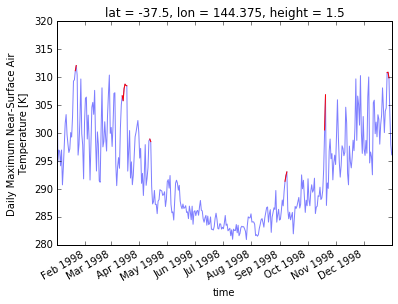

In [5]:
tasmax.sel(lat=-37.8, lon=144.9, method='nearest').sel(time='1998').plot(alpha=0.5)
candidates.sel(lat=-37.8, lon=144.9, method='nearest').sel(time='1998').plot(color='red')

To help with processing time series Xarray has rolling window functions, which can help with things like temporal smoothing.

I can use this to find times where there are consecutive candidates, by calling `.rolling(time=3)` to create a rolling window with three samples in the time dimension, then `.count()` on that to get the number of non-`nan` values. `.rolling()` works a lot like `.groupby()`, which we've previously seen

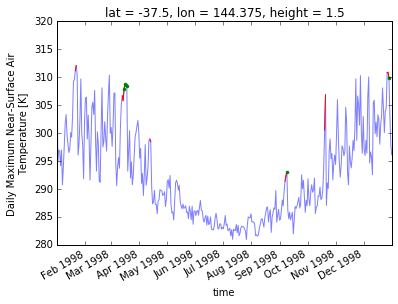

In [6]:
tasmax.sel(lat=-37.8, lon=144.9, method='nearest').sel(time='1998').plot(alpha=0.5)
candidates.sel(lat=-37.8, lon=144.9, method='nearest').sel(time='1998').plot(color='red')

# To plot this on the same axis I'm filtering the candidates with .where() to show times when a heatwave was found
candidates.where(
    candidates.rolling(time=3).count()==3
).sel(lat=-37.8, lon=144.9, method='nearest').sel(time='1998').plot(marker='.')

Let's now zoom in on a couple of the heatwaves to see what's happening. First the one in March:

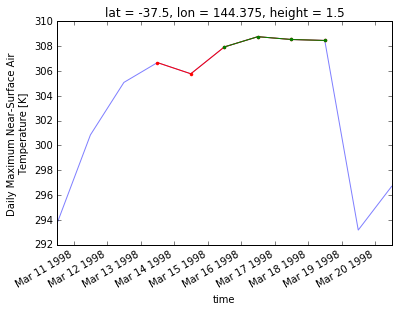

In [7]:
tasmax.sel(lat=-37.8, lon=144.9, method='nearest').sel(time=slice('19980310','19980320')).plot(alpha=0.5)
candidates.sel(lat=-37.8, lon=144.9, method='nearest').sel(time=slice('19980310','19980320')).plot(color='red', marker='.')

candidates.where(
    candidates.rolling(time=3).count()==3
).sel(lat=-37.8, lon=144.9, method='nearest').sel(time=slice('19980310','19980320')).plot(marker='.')

You can see here that the window function trails the data - only at the third candidate point is it marked as a heatwave. We've also got multiple marked points for a single heatwave, which will be a problem for counting.

Another interesting point to look at is something that wasn't maked as a heatwave, the spike in October

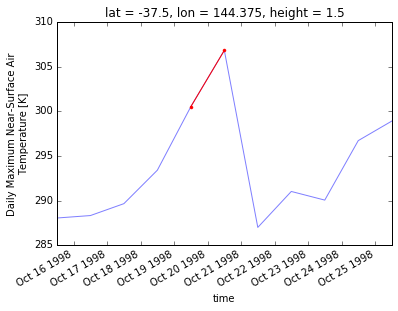

In [8]:
tasmax.sel(lat=-37.8, lon=144.9, method='nearest').sel(time=slice('19981015','19981025')).plot(alpha=0.5)
candidates.sel(lat=-37.8, lon=144.9, method='nearest').sel(time=slice('19981015','19981025')).plot(color='red', marker='.')

candidates.where(
    candidates.rolling(time=3).count()==3
).sel(lat=-37.8, lon=144.9, method='nearest').sel(time=slice('19981015','19981025')).plot(marker='.')

This is a run of only two candidate points, so it was correct to not mark as a heatwave.

As a first pass this works but it is a bit crude - it correctly identifies heatwaves, but doesn't allow us to count them. To do that, I need to define a custom filter function to apply to the window.

To count the heatwaves I need to be a bit more specific than I have been, since each instance occurs over a number of time points. Let's say I want to count the *starts* of the heatwaves - where it transitions from not a candidate to a candidate for 3 steps, so I want to match the pattern
```
[ nan, valid, valid, valid ]
```
with the second point being marked as the date the heatwave starts. To do this I've created the filter function below. So that the times get marked correctly the function is intended to be used with a centred window function - it returns true if the entry one to the left is `nan` and that the current entry plus the two to the right are finite values, false otherwise.

In [9]:
def rising_filter(array, axis):
    """
    Returns locations when the values of array go from nan to valid for at least 3 steps
    
    This should be used with a centred, 5 element window like
        x.rolling(time=5, center=True, min_periods=1).reduce(rising_filter)
        
    Note that applying this to a Dask array will load the entire input array
    """
    # Make sure there are enough points
    assert(array.shape[axis] == 5)
    # Make sure we're working on the last axis
    assert(axis == array.ndim-1 or axis == -1)
    
    left = array[..., 1]
    right = array[..., 2:].sum(axis=axis)

    return numpy.logical_and(numpy.isnan(left), numpy.isfinite(right))

In theory this function can be applied to our data using
```
heatwave_starts = candidates.rolling(time=5, center=True, min_periods=1).reduce(rising_filter)
```
unfortunately however this doesn't play well with dask, which is the library that handles loading the data from the input files as we need it. If we try then the entire 150 years of daily data gets loaded into memory, and our program will crash.

So that we don't need to load the whole array into memory, we need to wrap our filter function using `xarray.apply_ufunc(..., dask='parallelized')`. This tells dask that it can apply the filter on chunks one at a time, it doesn't need the whole array.

In [10]:
def rising_filter_dask(x, dim):
    """
    Helper function for applying rising_filter() to a dask array without loading the whole thing
    
    Use like
        rising_filter_dask(x.rolling(time=5, center=True, min_periods=1).construct('rolling_dim'),
                           dim='rolling_dim')
    """
    return xarray.apply_ufunc(rising_filter, x, input_core_dims=[[dim]],
                             kwargs={'axis': -1},
                             dask='parallelized',
                             output_dtypes=[bool])

The dask version of the filter has to be applied slightly differently - this seems to be a bug?

In [11]:
windows = candidates.chunk({'time':20}).rolling(time=5, center=True, min_periods=1).construct('rolling_dim')
heatwave_starts = rising_filter_dask(windows, dim='rolling_dim')

Finally we have a DataArray with the start time of every heatwave at every gridpoint in the ACCESS 1.3 historical run, that's pretty cheap to calculate - the run time of this notebook should be just a couple minutes.

From here we can do some analysis - where do heatwaves occur the most? how does the frequency change with time?

CPU times: user 32.3 s, sys: 8.53 s, total: 40.9 s
Wall time: 26.4 s


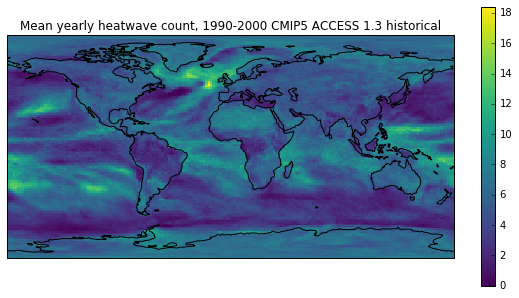

In [12]:
%%time

plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())
(heatwave_starts.sel(time=slice('1990','2000')).sum('time')/10).plot(ax=ax)
ax.coastlines()
ax.set_title('Mean yearly heatwave count, 1990-2000 CMIP5 ACCESS 1.3 historical')

CPU times: user 3min 1s, sys: 37.7 s, total: 3min 38s
Wall time: 2min 5s


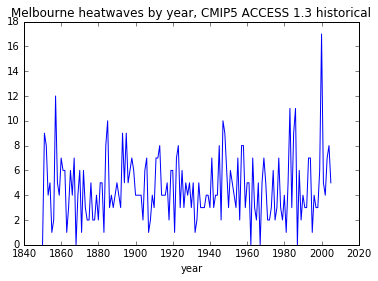

In [13]:
%%time

heatwave_starts.sel(lat=-37.8, lon=144.9, method='nearest').groupby('time.year').sum('time').plot()
plt.title('Melbourne heatwaves by year, CMIP5 ACCESS 1.3 historical')